In [ ]:
import pandas as pd
import numpy as np
import re

# import string

# import unicodedata

In [10]:
df_chat = pd.read_csv('prod_snapshot/firestore-chatHistory-prod.csv')
df_chat.head()
# df_chat.shape
# df_chat['id'].nunique()

,id,checkpoint_id,checkpoint_updated_channels,last_updated,messages,metadata,parent_checkpoint_id,v,versions
0,00003f6a-ef8e-11ef-8200-42004e494300,NaN,NaN,2025-02-20 13:28:25 UTC,"[{""role"":""assistant"",""content"":""\n ��� ...",NaN,NaN,NaN,NaN
1,00301794-6711-11f0-9532-42004e494300,NaN,NaN,2025-07-22 15:32:07 UTC,"[{""role"":""assistant"",""content"":""\n ��� ...",NaN,NaN,NaN,NaN
2,006de380-63f1-11f0-981e-42004e494300,NaN,NaN,2025-07-18 16:05:22 UTC,"[{""role"":""assistant"",""content"":""\n ��� ...",NaN,NaN,NaN,NaN
3,0155328a-caa8-11f0-8959-42004e494300,1f0caa80-366f-6f35-8001-c2e45062dcf5,WyJtZXNzYWdlcyJd,2025-11-26 09:12:20 UTC,"[{""role"":""user"",""content"":""Support for a famil...",eyJzb3VyY2UiOiAibG9vcCIsICJzdGVwIjogMSwgInBhcm...,1f0caa80-1f14-619e-8000-d9f5ce2882e0,4.0,eyJtZXNzYWdlcyI6IDMsICJicmFuY2g6dG86Y2hhdGJvdC...
4,01a58a42-c462-11f0-bf52-42004e494300,1f0c4623-07f5-640f-8004-7cdb05ddd92b,WyJtZXNzYWdlcyJd,2025-11-18 09:37:24 UTC,"[{""role"":""user"",""content"":""I am a poor student...",eyJzb3VyY2UiOiAibG9vcCIsICJzdGVwIjogNCwgInBhcm...,1f0c4622-eb0f-6427-8003-ba1630f1054f,4.0,eyJtZXNzYWdlcyI6IDYsICJicmFuY2g6dG86Y2hhdGJvdC...


In [11]:
df_query = pd.read_csv('prod_snapshot/firestore-userQuery-prod.csv')
df_query.head(1)
# df_query.shape
# df_query['id'].nunique()

,id,query_text,query_timestamp,schemes_response,session_id
0,00003f6a-ef8e-11ef-8200-42004e494300,I am looking for Caregiver Support that offers...,"Thu, 20 Feb 2025 13:24:23 GMT","[{""Quintile"":""5"",""Link"":""https://nulife.com.sg...",00003f6a-ef8e-11ef-8200-42004e494300


Data Cleaning

In [12]:
# Remove duplicate queries within a certain period (10 minutes) to prevent spam entries from interfering with analysis 

# Convert query_timestamp to datetime
df_query['query_timestamp'] = pd.to_datetime(
    df_query['query_timestamp'], 
    format="%a, %d %b %Y %H:%M:%S GMT",  # matches "Tue, 22 Jul 2025 15:31:56 GMT"
    utc=True
)

# Keep only the first query in each 10-minute window per unique query_text
df_query = df_query.groupby('query_text').apply(
    lambda g: g[g['query_timestamp'].diff().dt.total_seconds().div(60).fillna(999) > 10]
).reset_index(drop=True)

/tmp/ipykernel_11502/4059388193.py:11: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_query = df_query.groupby('query_text').apply(


In [13]:
# identifying (& removing) non-English queries

def replace_smart_chars(text):
    """
    Replace common non-ASCII quotes/apostrophes/dashes/ellipsis with ASCII.
    """
    if not isinstance(text, str):
        return text

    replacements = {
        '’': "'",   # right single quote
        '‘': "'",   # left single quote
        '“': '"',   # left double quote
        '”': '"',   # right double quote
        '–': '-',   # en dash
        '—': '-',   # em dash
        '…': '...', # ellipsis
    }

    for orig, repl in replacements.items():
        text = text.replace(orig, repl)

    return text

def contains_non_english(text):
    """
    Returns True if the text contains non-English characters,
    ignoring digits, punctuation, and spaces.
    """
    if not isinstance(text, str):
        return False

    # Replace smart chars first
    text = replace_smart_chars(text)

    # Remove digits, punctuation, spaces
    text_clean = re.sub(r'[\d\s!"#$%&\'()*+,-./:;<=>?@[\\\]^_`{|}~]', '', text)

    # If any character is non-ASCII, return True
    return bool(re.search(r'[^\x00-\x7F]', text_clean))

df_query = df_query[~df_query['query_text'].apply(contains_non_english)]


In [ ]:
# Remove irrelevant queries

import re
import nltk
from nltk.corpus import words
# nltk.download('words')

word_list = set(words.words())
irrelevant_phrases = {"hello", "hello there", "hi", "hi there", "help", "help me", "test", "testing", "care corner", "carecorner", "schemes sg", "schemes", "sg", 
                      "thank you", "thanks", "bye", "goodbye", "good bye", "toa payoh"}

def is_relevant_query(query):
    """
    Returns True if the query is relevant, False otherwise.
    Filters out:
      - Single letters
      - Only numbers
      - Only punctuation
      - Empty strings
      - Specific irrelevant phrases
    """

    if not isinstance(query, str) or query.strip() == "":
        return False

    # # Remove leading/trailing punctuation
    # query_clean = re.sub(r'^\W+|\W+$', '', query)

    # query_clean = re.sub(r"[^\w\s]", " ", query).strip().lower()  # lowercase, remove punctuations (replace with space)

    # query_clean = query.encode('ascii', 'ignore').decode()       # strip fancy punctuation
    # query_clean = re.sub(r"[^\w\s]", " ", query_clean, flags=re.UNICODE)
    # query_clean = re.sub(r"\s+", " ", query_clean).strip().lower()
    
    # 1. Single character
    if len(query) <= 1:
        return False
    
    # 2. Only numbers
    if query.isdigit():
        return False
    
    # 3. Only punctuation / symbols
    if not re.search(r'\w', query):
        return False
    
    # 4. Remove queries in the irrelevant phrases list
    if query in irrelevant_phrases:
        return False
    
    # Check tokens
    tokens = re.findall(r"[a-zA-Z]+", query)

    # Require at least one real word from dictionary
    if not any(t in word_list for t in tokens):
        return False
    
    # Otherwise, keep
    return True

df_clean = df_query[df_query['query_text'].apply(is_relevant_query)]

[nltk_data] Downloading package words to /home/sj/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


Identifying structured queries that follow the "I am ... looking for ..." format

In [19]:
# List of pre-defined categories on the portal
# I am {user_profiles} looking for {scheme_type} that offers {support}

user_profiles = ["Low-Income Individual or Family", "Parent or Family Member", "Elderly (Senior)", "Person with Disabilities or Special Needs", "Caregiver", "Child or Youth", 
                 "Ex-Offender or Incarcerated Individual", "Migrant or Foreign Worker", "Woman in Need of Support", "Facing Mental Health Challenges", 
                 "Homeless or in Need of Shelter", "Dealing with Addictions or Recovery", "Facing End-of-Life or Terminal Illness", "In Need of Legal Aid", 
                 "Experiencing Abuse or Violence"]

scheme_type = ["Financial Assistance Programs", "Food Support", "Housing Assistance", "Shelter Services", "Healthcare Services", "Mental Health Support", "Education Programs", 
               "Employment Assistance", "Caregiver Support", "Transport Services", "Legal Aid Services", "Addiction Recovery Services", "Family Support Services", 
               "Disability Support Services", "Palliative Care Services", "Social Work & Casework"]

support = ["Financial Assistance", "Food Support", "Housing Assistance", "Healthcare Services", "Mental Health Support", "Education Opportunities", "Employment Support", 
           "Caregiver Assistance", "Transport Mobility Support", "Legal Aid Services", "Addiction Recovery Services", "Parenting Support", "Disability Support", 
           "Palliative Care Services", "Social Work Services"]

In [20]:
# Keep punctuations intact for now (to match with keywords that have punctuations in them)

def clean_text(text):
    # text = re.sub(r"[^a-zA-Z\s]", " ", text)  # keep only letters & spaces
    text = re.sub(r"[^a-zA-Z\s.,!?&'\-()]", " ", text) # Keep all common punctuation
    return text

# df_profile = df_clean.loc[df_clean['query_text'].str.contains(r"\bi am\b.*\blooking for\b.*\bthat offers\b", case=False, na=False)].copy()
df_profile = df_clean.loc[df_clean['query_text'].str.contains(r"\bi am\b.*\blooking for\b.", case=False, na=False)].copy()

# astype(str) converts NaN and floats into the string "nan", which is safe to search.
# ✅ na=False ensures missing values are treated as non-matches, not errors.
df_profile.loc[:, 'clean_query'] = df_profile['query_text'].astype(str).apply(clean_text)

# pattern = re.compile(r"\bi am\b\s*(.*?)\s*\blooking for\b\s*(.*?)\s*\bthat offers\b\s*(.*)", re.IGNORECASE)
pattern = re.compile(r"\bi\s*am(?:\s+(.*?))?\s+looking for\s+(.*)", re.IGNORECASE)

# def extract_profile(query):
#     match = pattern.search(query)
#     if match:
#         who = match.group(1).strip() if match.group(1) else ""   # blank if not provided
#         what = match.group(2).strip()
#         return who, what
#     return None, None

df_profile[['who_am_i', 'looking_for']] = df_profile['clean_query'].fillna("").str.extract(pattern).astype(str)
# df_profile.loc[:, ['who_am_i', 'looking_for']] = df_profile['clean_query'].apply(lambda x: pd.Series(extract_profile(x)))

In [ ]:
# Filter out queries for user profiles that do not have any matches in the respective list:

# df_profile_filtered = df_profile[~((df_profile['who_am_i'].isin(user_profiles)) | (df_profile['who_am_i'].str.strip() == ""))]

In [ ]:
# print(df_profile[df_profile['id'] == '068a5baa-39d9-11f0-89bf-42004e494300']['query_text'].squeeze())
# print(df_profile[df_profile['id'] == '0cb6f3d6-f99b-11ef-9f34-42004e494300']['query_text'].squeeze())

In [ ]:
# Manual corrections for specific entries

# df_profile.loc[df_profile['id'] == '068a5baa-39d9-11f0-89bf-42004e494300', 'who_am_i'] = ["Homeless or in Need of Shelter"]
# # df_profile.loc[df_profile['id'] == '0cb6f3d6-f99b-11ef-9f34-42004e494300', 'who_am_i'] = [["Person with Disabilities or Special Needs", "Child or Youth"]]

# # Above does not work. .at bypasses pandas’ broadcasting logic, guarantees the list is stored as a list, not coerced to NaN

# # Step 1: find the index of the row
# idx = df_profile.index[df_profile['id'] == '0cb6f3d6-f99b-11ef-9f34-42004e494300'][0]

# # Step 2: assign the list
# df_profile.at[idx, 'who_am_i'] = ["Person with Disabilities or Special Needs", "Child or Youth"]

Identifying narrative/unstructured queries that do not follow the "I am ... looking for ..." format

In [21]:
# remove punctuations for easier manual matching of words

df_clean['query_text'] = (
    df_clean['query_text']
    .str.replace(r"[^\w\s]", " ", regex=True)
    .str.replace(r"\s+", " ", regex=True)
    .str.strip()
    .str.lower()
)

df_untag = df_clean.loc[~df_clean['query_text'].str.contains(r"\bi am\b.*\blooking for\b", case=False, na=False)].copy()

/tmp/ipykernel_11502/1087688024.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['query_text'] = (


In [ ]:
# Test 1

# df_untag['clean_test'] = df_untag['query_text'].apply(
#     lambda x: re.sub(r"[^\w\s]", " ", str(x)).strip().lower()
# )
# print(df_untag['clean_test'].head())

In [ ]:
# Test 2

# (df_untag['query_text'].str.contains(r"[^\w\s]", regex=True)).any()

Identifying common keywords

In [ ]:
# import spacy
# from wordcloud import WordCloud
# import matplotlib.pyplot as plt

# # Load English model (run once)
# # python -m spacy download en_core_web_sm
# nlp = spacy.load("en_core_web_sm")

# # # Example DataFrame
# # df_free = pd.DataFrame({
# #     'query_text': [
# #         "I'm trying to quit drinking but it's really hard on my own.",
# #         "I’m 38 and just started caring for my wife full-time.",
# #         "Looking for caregiver support after surgery.",
# #         "I want to find a group to talk about anxiety and stress."
# #     ]
# # })

# def extract_nouns_verbs(text):
#     """
#     Extract only nouns and verbs from text using spaCy.
#     """
#     if not isinstance(text, str):
#         return []

#     doc = nlp(text.lower())
#     words = [token.lemma_ for token in doc 
#              if (token.pos_ in ["NOUN", "VERB"]) and not token.is_stop and token.is_alpha]
#     return words

# # Collect all words
# all_words = []
# df_untag['query_text'].dropna().apply(lambda x: all_words.extend(extract_nouns_verbs(x)))

# # Generate word cloud
# wordcloud = WordCloud(width=800, height=400, background_color="white").generate(" ".join(all_words))

# # Plot
# plt.figure(figsize=(10,5))
# plt.imshow(wordcloud, interpolation="bilinear")
# plt.axis("off")
# plt.show()

[nltk_data] Downloading package punkt to /home/sj/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /home/sj/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/sj/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /home/sj/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package stopwords to /home/sj/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


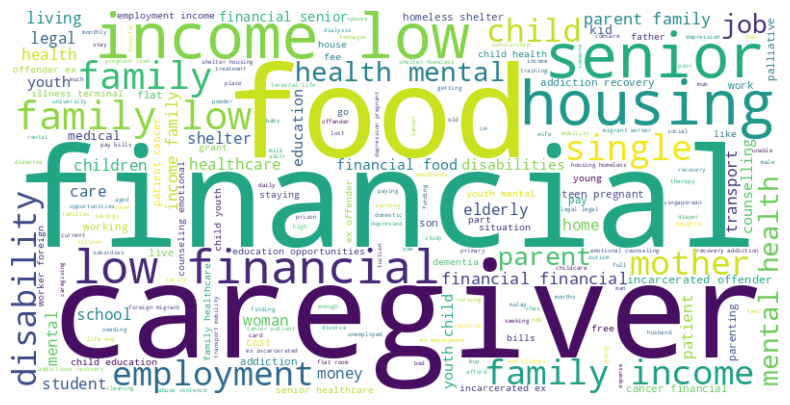

In [ ]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize, pos_tag
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# Make sure you have NLTK data installed once
# nltk.download('punkt')
# nltk.download('punkt_tab')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('averaged_perceptron_tagger_eng')
# nltk.download('stopwords') 

all_words = []
phrases_to_exclude = ["social work", "toa payoh", "care corner", "years old", "years-old", "year-old", "year old"]

# custom_stopwords = set(STOPWORDS)
custom_stopwords = set(stopwords.words("english"))
custom_stopwords.update(["month", "year", "years", "available", "support", "supporting", "provide", "provides", "providing", "deal", "deals", "dealing", "resources", "service", "services", "programs", "program", "programme", "programmes", 
                         "issue", "issues", "problem", "problems", "challenges", "challenge", "challenging", "require", "requiring", "need", "needs", "want", "looking", "for", "assistance", "assist", "aid", "get",
                         "help", "helping", "test", "prompt", "hi", "hello", "schemes", "scheme", "offers", "offer", "offering", "find", "know", "worried", "worry", "suffering", "suffer", "struggling", "struggle", 
                         "experiencing", "experience", "facing", "face", "apply", "applying", "singapore", "centre", "client", "person", "member", "casework", "carecorner", "special", "individual", "time"]) 

def clean_text(text):
    for phrase in phrases_to_exclude:
        text = text.lower().replace(phrase, "")
    return text

def extract_nouns_verbs_adj(text):

    if not isinstance(text, str):
        return []
    
    cleaned = clean_text(text)

    tokens = word_tokenize(cleaned.lower())
    tokens = [t for t in tokens if t.isalpha()]  # keep only words
    # tokens = [t for t in tokens if t.isalnum()]  # keep words and numbers
    tagged = pos_tag(tokens)

    # Keep nouns (NN, NNS, NNP, NNPS) and verbs (VB, VBD, VBG, VBN, VBP, VBZ)
    # words = [word for word, pos in tagged if pos.startswith("NN") or pos.startswith("VB")]
    words = [word for word, pos in tagged if pos.startswith(("NN", "VB", "JJ"))]

    # Remove stopwords
    # stop_words = set(stopwords.words("english"))
    words = [w for w in words if w not in custom_stopwords]

    return words

def unique_words_per_query(text):
    words = extract_nouns_verbs_adj(text)
    return list(set(words))

df_clean['query_text'].dropna().apply(lambda x: all_words.extend(unique_words_per_query(x)))

# filtered_words = [w for w in all_words if w.lower() not in custom_stopwords]

wordcloud = WordCloud(width=800, height=400, background_color="white", stopwords=custom_stopwords).generate(" ".join(all_words))

plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# df_word_cloud = pd.DataFrame(all_words, columns=['word'])
# unique_words = df_word_cloud['word'].unique()

# df_unique_words = pd.DataFrame(unique_words, columns=['word'])
# df_unique_words.to_csv('word_cloud.csv', index=False)

# pd.DataFrame({'word': list(set(all_words))}).to_csv('word_cloud.csv', index=False)

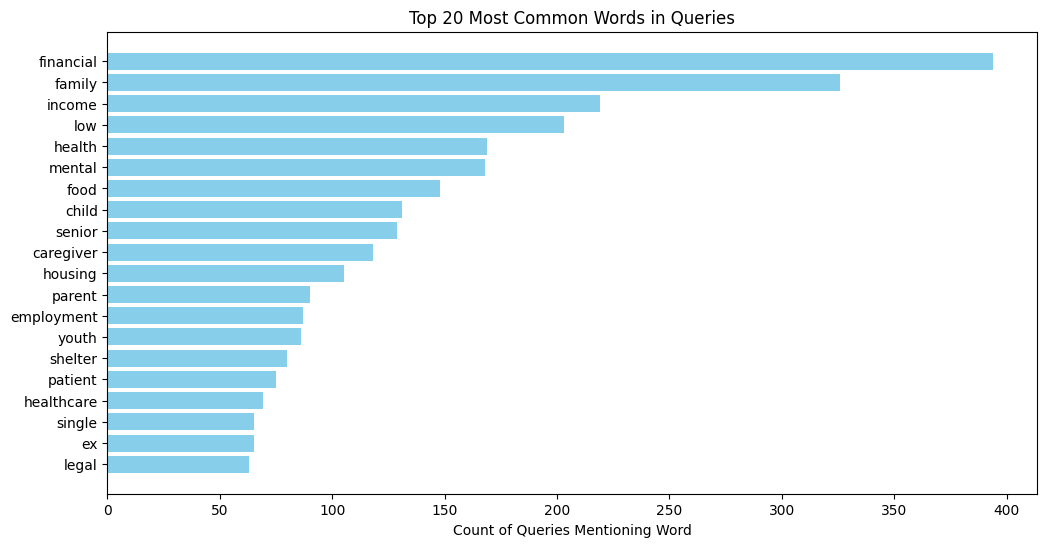

In [25]:
# Most common words in queries

from collections import Counter
import matplotlib.pyplot as plt

word_counts = Counter(all_words)
top_n = 20 
common_words = word_counts.most_common(top_n)

words, counts = zip(*common_words)

plt.figure(figsize=(12, 6))
plt.barh(words, counts, color="skyblue")
plt.xlabel("Count of Queries Mentioning Word")
plt.title(f"Top {top_n} Most Common Words in Queries")
plt.gca().invert_yaxis()  # largest at top
plt.show()

In [ ]:
from itertools import combinations
from collections import Counter
import pandas as pd

# You already have: all_words = [] and df_clean with 'query_text'

# --- Step 1. Create a list of word sets per query ---
word_sets = []
for text in df_clean['query_text'].dropna():
    word_list = unique_words_per_query(text)
    if word_list:
        word_sets.append(set(word_list))

# --- Step 2. Build co-occurrence pairs ---
cooccur = Counter()
for words in word_sets:
    for w1, w2 in combinations(sorted(words), 2):  # sorted ensures ('a','b') == ('b','a')
        cooccur[(w1, w2)] += 1

# --- Step 3. Convert to DataFrame for easy analysis ---
df_cooccur = (
    pd.DataFrame([(a, b, c) for (a, b), c in cooccur.items()],
                 columns=['word1', 'word2', 'count'])
    .sort_values('count', ascending=False)
)

# Optional: Filter out weak co-occurrences (e.g. < 5)
df_cooccur = df_cooccur[df_cooccur['count'] >= 5].reset_index(drop=True)

print(df_cooccur.head(30))

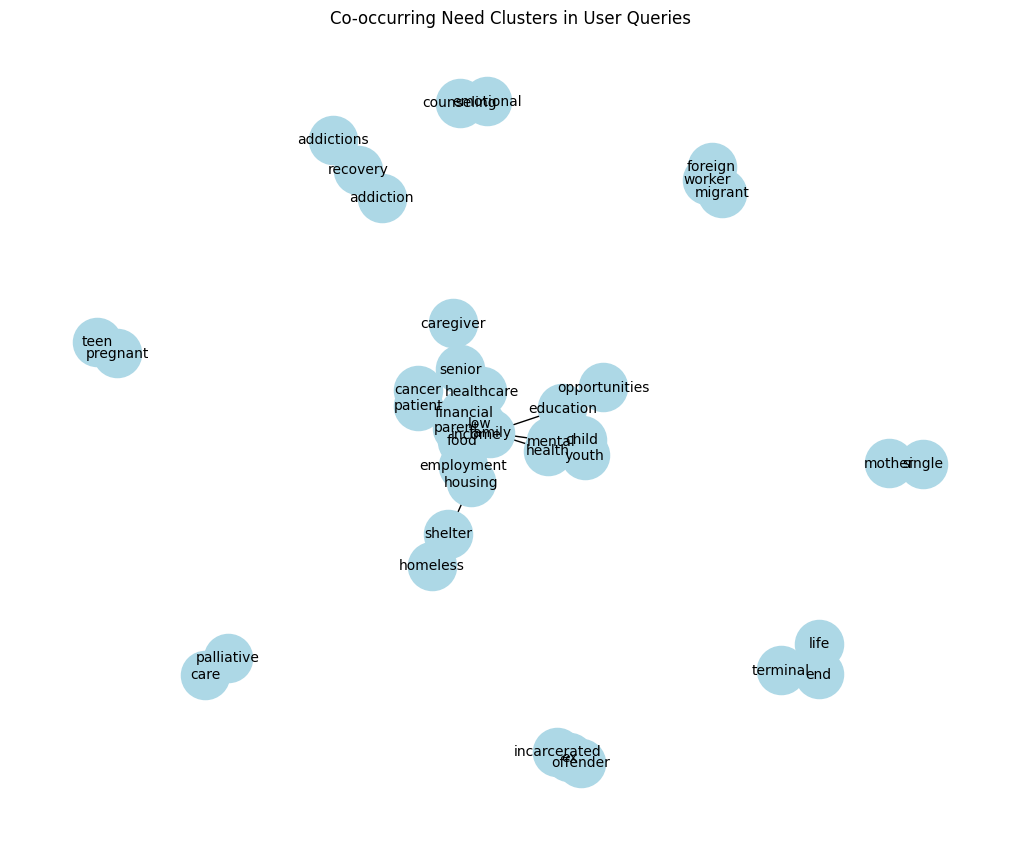

In [30]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a graph
G = nx.Graph()

# Add edges with weight = co-occurrence count
for _, row in df_cooccur.iterrows():
    G.add_edge(row['word1'], row['word2'], weight=row['count'])

# Keep only the top 50 edges for clarity
edges_to_plot = sorted(G.edges(data=True), key=lambda x: x[2]['weight'], reverse=True)[:50]
H = nx.Graph()
H.add_edges_from([(a, b, d) for a, b, d in edges_to_plot])

plt.figure(figsize=(10, 8))
pos = nx.spring_layout(H, k=0.5, seed=42)
nx.draw(H, pos, with_labels=True, node_color='lightblue', node_size=1200, font_size=10, width=1)
plt.title("Co-occurring Need Clusters in User Queries")
plt.show()

Largest community size: 8 nodes
Identified 2 sub-clusters within the largest cluster


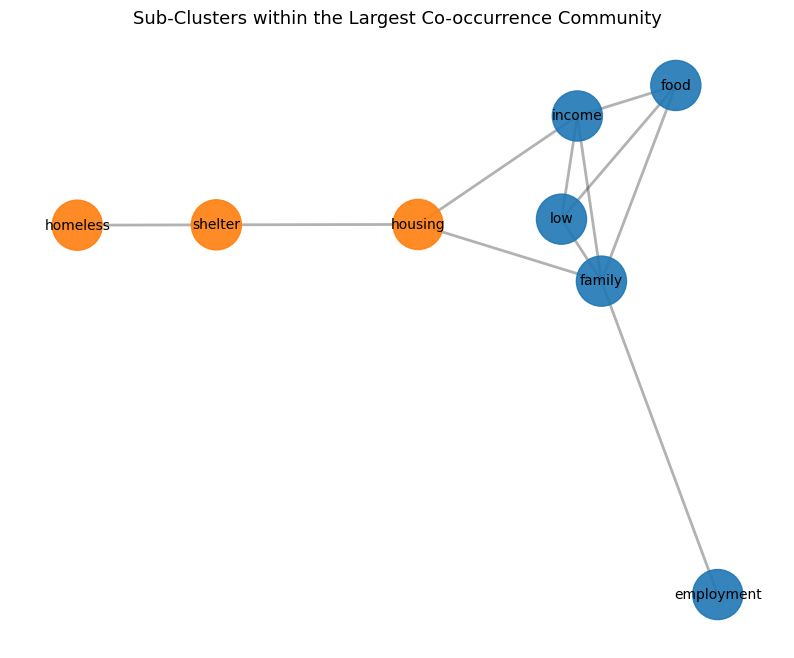


🟩 Sub-cluster 1 (5 words):
employment, family, food, income, low

🟩 Sub-cluster 2 (3 words):
homeless, housing, shelter


In [31]:
import networkx as nx
import matplotlib.pyplot as plt
import networkx.algorithms.community as nx_comm

# --- 1️⃣ Identify the largest community in your existing graph ---
communities = nx_comm.greedy_modularity_communities(H)
# for i, c in enumerate(communities, 1):
#     print(f"Cluster {i}: {', '.join(sorted(c))}")
largest_cluster_nodes = max(communities, key=len)
print(f"Largest community size: {len(largest_cluster_nodes)} nodes")

# --- 2️⃣ Create a subgraph for just that cluster ---
G_sub = H.subgraph(largest_cluster_nodes).copy()

# --- 3️⃣ Run sub-community detection inside this subgraph ---
sub_communities = nx_comm.greedy_modularity_communities(G_sub)
print(f"Identified {len(sub_communities)} sub-clusters within the largest cluster")

# --- 4️⃣ Assign colours for visual clarity ---
color_map = {}
palette = plt.cm.tab10.colors  # You can switch to plt.cm.Set3 for softer colours
for i, c in enumerate(sub_communities):
    for node in c:
        color_map[node] = palette[i % len(palette)]

# --- 5️⃣ Visualise the sub-clusters ---
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G_sub, k=0.7, seed=42)

nx.draw_networkx_nodes(
    G_sub, pos,
    node_color=[color_map.get(node, "lightgrey") for node in G_sub.nodes()],
    node_size=1300,
    alpha=0.9
)
nx.draw_networkx_edges(G_sub, pos, alpha=0.3, width=2)
nx.draw_networkx_labels(G_sub, pos, font_size=10)
plt.title("Sub-Clusters within the Largest Co-occurrence Community", fontsize=13)
plt.axis("off")
plt.show()

# --- 6️⃣ Print out sub-cluster words for interpretation ---
for i, c in enumerate(sub_communities, 1):
    print(f"\n🟩 Sub-cluster {i} ({len(c)} words):")
    print(", ".join(sorted(c)))

Classifying user profiles and schemes

In [32]:
import re

# --- Predefined Categories ---
SCHEME_CATEGORIES = {
    "Financial Assistance Programs": ["financial", "financials", "financially", "finances", "finance", "earning", "earnings", "grant", "grants", "poor", "poverty", "cost", "costs", "fees", 
                                      "subsidy", "subsidies", "money", "bills", "borrow", "pay", "paying", "payment", "savings", "rebates", "rebate", "grants", "grant", "loans", "loan", 
                                      "debts", "debt", "comcare", "workfare", "bankrupt", "fines", "arrears", "vouchers", "voucher", "afford", "affordable", "budget", "budgeting", 
                                      "chas", "scholarship", "scholarships", "bursary", "bursaries", "bonus", "bonuses", "payout", "payouts", "fund", "funds", "funding", "cdc", "cpf",
                                      "medisave", "medifund", "medishield", "silver support", "skillsfuture", "insurance", "expenses"],
    "Food Support": ["food", "meal", "meals", "groceries", "milk"],
    "Housing Assistance": ["housing", "house", "ownership", "evicted", "evict", "eviction", "rent", "rental", "flat", "hostel", "property", "landlord", "lease", "accommodation", 
                           "temporary housing", "hoard", "hoarding", "declutter", "decluttering", "hdb", "bto"],
    "Shelter Services": ["shelter", "shelters", "homeless", "rough sleeping", "rough sleeper"],
    "Healthcare Services": ["illness", "ill", "sick", "doctor", "nurse", "patient", "tcm", "hospital", "treatment", "healthcare", "medical", "medicine", "medication", "clinic", 
                            "appointment", "appointments", "health screening"],
    "Mental Health Support": ["therapy", "therapist", "mental", "depression", "depressed", "anxieties", "anxiety", "anxious", "suicidal", "suicide"],
    "Education Programs": ["school", "tuition", "education", "poly", "uni", "university", "academic"],
    "Employment Assistance": ["job", "jobs", "jobless", "work", "layoff", "skills", "upskill", "upskilling", "development", "part time", "employment", "career", "training", "retrenched", "retrenchment", 
                              "layoff", "fired", "unemployed", "workfare", "gig", "freelance"],
    "Caregiver Support": ["caregiver", "caregiving", "take care", "respite", "helper", "homebound", "bedridden"],
    "Transport Services": ["transport", "bus", "fare", "shuttle", "get around"],
    "Legal Aid Services": ["legal", "lawyer", "court", "sue"],
    "Addiction Recovery Services": ["alcohol", "drinking", "drug", "drugs", "addiction", "rehab", "kpod", "halfway"],
    "Family Support Services": ["family support", "family service", "childcare", "child care", "daycare", "home care", "home care", "orphanage", "custody", "divorce", "divorced", "marriage", "married",
                                "nursing", "elder care", "eldercare", "old aged home", "old folks home", "dementia", "adoption", "foster", "fostering", "parenting", "baby", "active ageing", "active aging"],
    "Disability Support Services": ["disability", "special needs", "wheelchair"],
    "Palliative Care Services": ["end of life", "terminal", "terminally ill", "final stage", "advanced stage", "palliative", "hospice", "cancer", "dying"],
    "Social Work & Casework": ["social worker", "social work", "counselling", "counsellor", "behavioural", "risk", "anger", "abuse", "harrassment", "violence", "sexual", "rape", "boys home", 
                               "girls home", "emotional", "emotions", "talk to", "trauma", "mediate", "mediation", "psychologist", "therapist", "therapy", "relationships", "relationship"],
}

USER_PROFILES = {
    "Low-Income Individual or Family": ["income", "budget", "finances", "financials", "financial", "financially", "poor", "afford", "underprivileged"],
    "Parent or Family Member": ["parent", "parents", "mother", "mum", "father", "dad", "family member", "divorce", "divorced", "baby"],
    "Elderly (Senior)": ["elderly", "elders", "elder", "senior", "seniors", "old age", "ageing", "aging", "old folks"],
    "Person with Disabilities or Special Needs": ["pwd", "disabled", "disability", "disabilities", "handicapped", "special needs", "syndrome", "autism", "autistic", 
                                                  "bedridden", "bed ridden", "bed-ridden", "disorder"],
    "Caregiver": ["caregiver", "caregiving", "caring", "look after", "daytime support", "homebound", "bedridden"],
    "Child or Youth": ["teen", "teenage", "teenager", "youth", "youths", "student", "students", "orphan", "exam", "exams", "rebellious", "tuition", "underaged"],
    "Ex-Offender or Incarcerated Individual": ["offender", "offenders", "prison", "jail", "released"],
    "Migrant or Foreign Worker": ["migrant", "migrants", "foreign worker", "domestic worker", "maid", "helper", "transnational"],
    "Woman in Need of Support": ["woman", "single mother", "single mothers", "single mum", "single mums", "young mother", "young mothers", "young mum", "young mums", "widow", "female", "milk", 
                                 "abortion", "pregnant", "pregnancy"],
    "Facing Mental Health Challenges": ["depression", "depressed", "depressive", "anxious", "anxiety", "anxieties", "mental", "therapy", "therapist", "lonely", "no friends", "no friend", 
                                        "isolated", "suicidal", "suicide"],
    "Homeless or in Need of Shelter": ["homeless", "no home", "shelter", "rough sleeping", "evicted"],
    "Dealing with Addictions or Recovery": ["alcohol", "drinking", "gambling", "addiction", "addictions", "rehab", "rehabilitation", "drugs", "vaping", "vape", "kpod", "sex", "porn", 
                                            "pornography", "gaming", "games"],
    "Facing End-of-Life or Terminal Illness": ["end of life", "terminal", "terminally ill", "palliative", "final stage", "advanced stage", "cancer", "dying"],
    "In Need of Legal Aid": ["legal", "lawyer", "court"],
    "Experiencing Abuse or Violence": ["abuse", "abused", "abusive", "violence", "violent", "sexual", "rape", "bullying", "bullied", "bullies", "bully", "harassment", "harassed"],
}

# --- Classification Function ---
def classify_query(query: str):
    query_lower = query.lower()
    
    matched_schemes = [
        scheme for scheme, keywords in SCHEME_CATEGORIES.items()
        if any(re.search(rf"\b{kw}\b", query_lower) for kw in keywords)
    ]
    
    matched_profiles = [
        profile for profile, keywords in USER_PROFILES.items()
        if any(re.search(rf"\b{kw}\b", query_lower) for kw in keywords)
    ]
    
    return {
        "query": query,
        "schemes": matched_schemes or ["Unclassified"],
        "profiles": matched_profiles or ["Unclassified"]
    }

In [33]:
df_profile["classification"] = df_profile["who_am_i"].apply(classify_query)
df_profile["profile_category"] = df_profile["classification"].apply(lambda x: x["profiles"])
df_profile = df_profile.drop(columns=["classification"])

df_profile["classification"] = df_profile["looking_for"].apply(classify_query)
df_profile["scheme_category"] = df_profile["classification"].apply(lambda x: x["schemes"])
df_profile = df_profile.drop(columns=["classification"])

df_profile_filtered = df_profile[['query_text', 'query_timestamp', 'scheme_category', 'profile_category']] \
[~((df_profile['scheme_category'].apply(lambda x: "Unclassified" in x)) | (df_profile['profile_category'].apply(lambda x: "Unclassified" in x)))] \
.sort_values(by='query_timestamp')

df_profile.to_csv('profile_classification.csv', index=False)

# df_profile2 = df_profile[['query_text', 'query_timestamp', 'scheme_category', 'profile_category']]

In [ ]:
df_profile[df_profile["scheme_category"].apply(lambda x: "Unclassified" in x) & df_profile["profile_category"].apply(lambda x: "Unclassified" in x)].shape

In [34]:
df_untag["classification"] = df_untag["query_text"].apply(classify_query)

df_untag["scheme_category"] = df_untag["classification"].apply(lambda x: x["schemes"])
df_untag["profile_category"] = df_untag["classification"].apply(lambda x: x["profiles"])

df_untag = df_untag.drop(columns=["classification"])

df_untag_filtered = df_untag[['query_text', 'query_timestamp', 'scheme_category', 'profile_category']] \
[~((df_untag['scheme_category'].apply(lambda x: "Unclassified" in x)) | (df_untag['profile_category'].apply(lambda x: "Unclassified" in x)))] \
.sort_values(by='query_timestamp')

# df_untag2 = df_untag[['query_text', 'query_timestamp', 'scheme_category', 'profile_category']]

In [35]:
df_merged = pd.concat([df_profile_filtered, df_untag_filtered], ignore_index=True).sort_values(by='query_timestamp')
# df_merged.to_csv('classification.csv', index=False)

# df_merged_all = pd.concat([df_profile2, df_untag2], ignore_index=True)
# df_merged_all.to_csv('all_classification.csv', index=False)

Analysis

In [36]:
df_exploded = df_merged.explode('profile_category').explode('scheme_category')
df_exploded

,query_text,query_timestamp,scheme_category,profile_category
0,I am Caregiver looking for Family Support Serv...,2024-12-29 11:42:33+00:00,Healthcare Services,Caregiver
0,I am Caregiver looking for Family Support Serv...,2024-12-29 11:42:33+00:00,Family Support Services,Caregiver
1,I am Facing End-of-Life or Terminal Illness lo...,2024-12-29 13:14:19+00:00,Palliative Care Services,Facing End-of-Life or Terminal Illness
2,I am Facing Mental Health Challenges looking f...,2024-12-29 14:20:02+00:00,Caregiver Support,Facing Mental Health Challenges
2,I am Facing Mental Health Challenges looking f...,2024-12-29 14:20:02+00:00,Legal Aid Services,Facing Mental Health Challenges
...,...,...,...,...
1274,cancer patient in need of financial assistance,2026-01-01 15:13:54+00:00,Healthcare Services,Low-Income Individual or Family
1274,cancer patient in need of financial assistance,2026-01-01 15:13:54+00:00,Palliative Care Services,Low-Income Individual or Family
1274,cancer patient in need of financial assistance,2026-01-01 15:13:54+00:00,Financial Assistance Programs,Facing End-of-Life or Terminal Illness
1274,cancer patient in need of financial assistance,2026-01-01 15:13:54+00:00,Healthcare Services,Facing End-of-Life or Terminal Illness


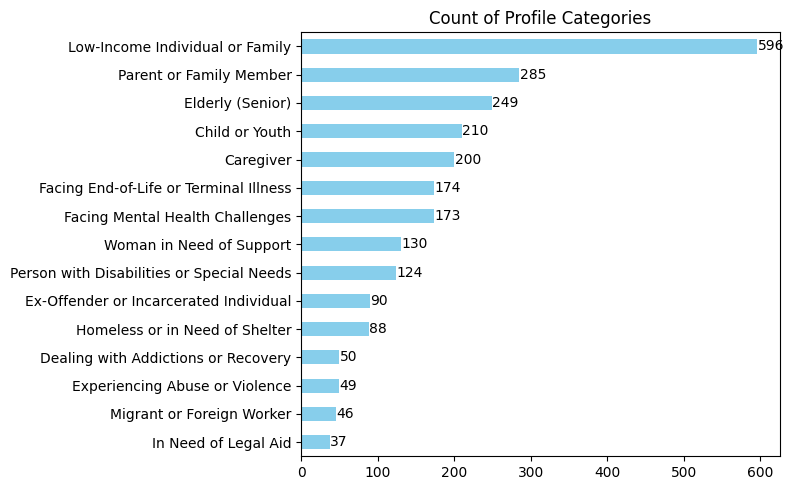

In [37]:
# Profile Categories

import matplotlib.pyplot as plt
profile_counts = df_exploded['profile_category'].value_counts()

plt.figure(figsize=(8, 5))
ax = profile_counts.plot(kind='barh', color='skyblue')
plt.title('Count of Profile Categories')
# plt.xlabel('Count')
# plt.ylabel('Profile Category')
plt.ylabel('')
plt.gca().invert_yaxis()  # Highest value on top

for i, v in enumerate(profile_counts):
    ax.text(v + 0.5, i, str(v), color='black', va='center')

plt.tight_layout()
plt.show()

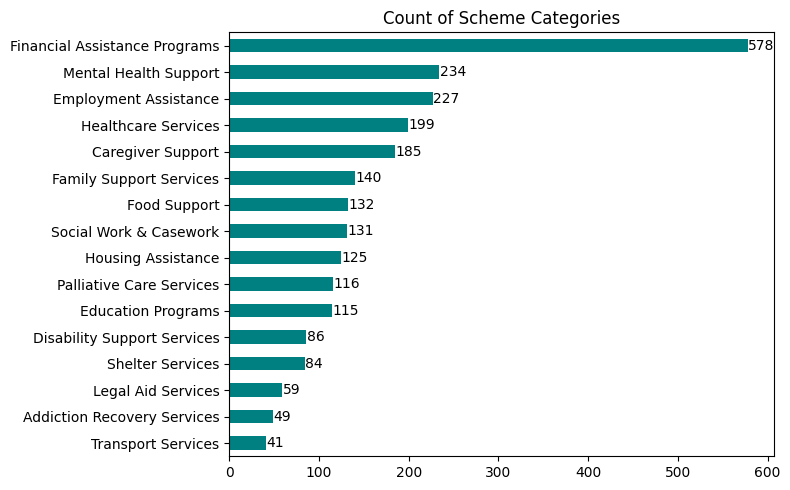

In [38]:
# Scheme Categories

scheme_counts = df_exploded['scheme_category'].value_counts()

plt.figure(figsize=(8, 5))
ax = scheme_counts.plot(kind='barh', color='teal')
plt.title('Count of Scheme Categories')
# plt.xlabel('Count')
# plt.ylabel('Scheme Category')
plt.ylabel('')
plt.gca().invert_yaxis()

for i, v in enumerate(scheme_counts):
    ax.text(v + 0.5, i, str(v), color='black', va='center')

plt.tight_layout()
plt.show()

In [ ]:
# scheme_counts

In [39]:
schemes_demand_counts = (
    df_exploded['scheme_category']
    .value_counts()
    .reset_index()
    .rename(columns={'scheme_category': 'schemes', 'count': 'demand_count'})
)

schemes_demand_counts.head()

,schemes,demand_count
0,Financial Assistance Programs,578
1,Mental Health Support,234
2,Employment Assistance,227
3,Healthcare Services,199
4,Caregiver Support,185


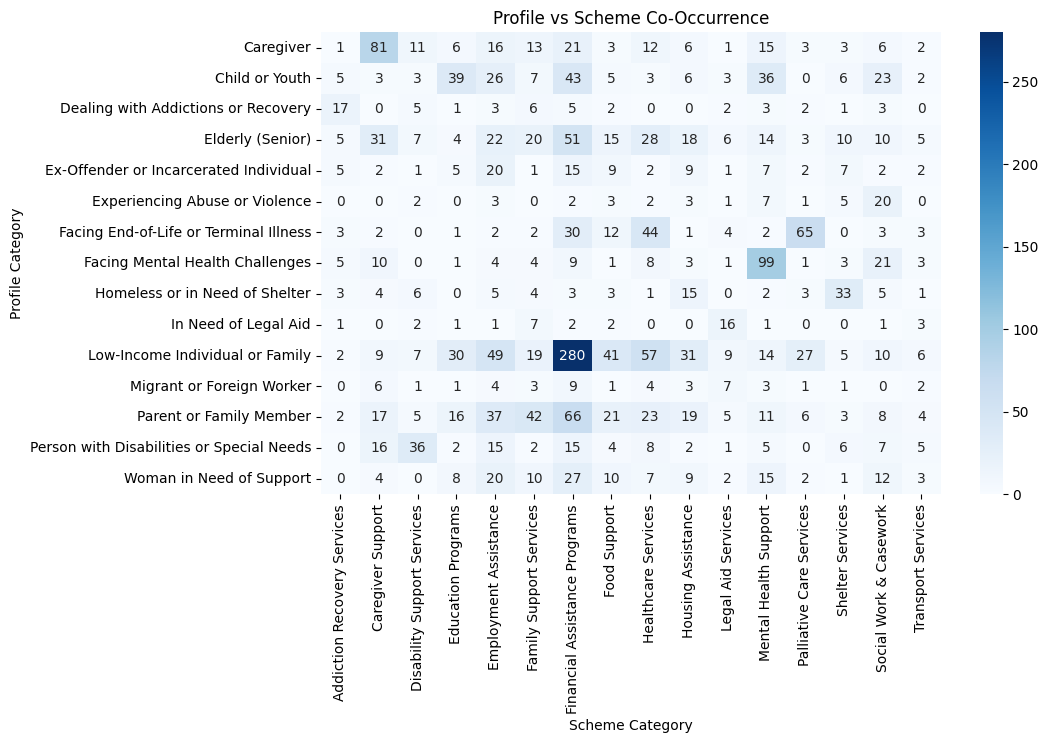

In [40]:
cross = pd.crosstab(df_exploded['profile_category'], df_exploded['scheme_category'])

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.heatmap(cross, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Scheme Category')
plt.ylabel('Profile Category')
plt.title("Profile vs Scheme Co-Occurrence")
plt.show()

In [41]:
import itertools
from collections import Counter

pairs = []
for cats in df_merged['profile_category']:
    pairs += list(itertools.combinations(sorted(cats), 2))

pd.Series(pairs).value_counts()

(Parent or Family Member, Woman in Need of Support)                          30
(Facing End-of-Life or Terminal Illness, Low-Income Individual or Family)    27
(Low-Income Individual or Family, Parent or Family Member)                   25
(Low-Income Individual or Family, Woman in Need of Support)                  19
(Child or Youth, Facing Mental Health Challenges)                            16
                                                                             ..
(Elderly (Senior), Facing Mental Health Challenges)                           1
(Migrant or Foreign Worker, Parent or Family Member)                          1
(Elderly (Senior), Facing End-of-Life or Terminal Illness)                    1
(Caregiver, Woman in Need of Support)                                         1
(Experiencing Abuse or Violence, Parent or Family Member)                     1
Name: count, Length: 61, dtype: int64

In [42]:
import itertools
from collections import Counter

pairs = []
for cats in df_merged['scheme_category']:
    pairs += list(itertools.combinations(sorted(cats), 2))

pd.Series(pairs).value_counts()

(Financial Assistance Programs, Healthcare Services)      63
(Employment Assistance, Social Work & Casework)           55
(Employment Assistance, Financial Assistance Programs)    46
(Healthcare Services, Palliative Care Services)           45
(Financial Assistance Programs, Food Support)             36
                                                          ..
(Housing Assistance, Transport Services)                   1
(Legal Aid Services, Shelter Services)                     1
(Education Programs, Family Support Services)              1
(Housing Assistance, Palliative Care Services)             1
(Food Support, Mental Health Support)                      1
Name: count, Length: 105, dtype: int64

In [43]:
import itertools
import pandas as pd

pairs_schemes = []

for _, row in df_merged.iterrows():
    profiles = row['profile_category']
    schemes = row['scheme_category']

    if isinstance(profiles, list) and isinstance(schemes, list):
        for pair in itertools.combinations(sorted(profiles), 2):
            for scheme in schemes:
                pairs_schemes.append({'profile_pair': pair, 'scheme': scheme})

df_pairs = pd.DataFrame(pairs_schemes)

# Count how often each (profile_pair, scheme) combination appears
pair_scheme_counts = (
    df_pairs.groupby(['profile_pair', 'scheme'])
    .size()
    .reset_index(name='count')
    .sort_values('count', ascending=False)
)

pair_scheme_counts.head(10)

,profile_pair,scheme,count
110,"(Facing End-of-Life or Terminal Illness, Low-I...",Palliative Care Services,27
107,"(Facing End-of-Life or Terminal Illness, Low-I...",Financial Assistance Programs,23
162,"(Low-Income Individual or Family, Parent or Fa...",Financial Assistance Programs,21
109,"(Facing End-of-Life or Terminal Illness, Low-I...",Healthcare Services,21
37,"(Child or Youth, Facing Mental Health Challenges)",Mental Health Support,16
195,"(Parent or Family Member, Woman in Need of Sup...",Financial Assistance Programs,14
42,"(Child or Youth, Low-Income Individual or Family)",Financial Assistance Programs,13
0,"(Caregiver, Elderly (Senior))",Caregiver Support,13
173,"(Low-Income Individual or Family, Woman in Nee...",Financial Assistance Programs,13
24,"(Caregiver, Person with Disabilities or Specia...",Caregiver Support,11


In [44]:
# import csv

# with open('filtered_chats.csv', 'w', newline='') as csvfile:
#     # Create a csv.writer object
#     writer = csv.writer(csvfile)

#     # Write all rows at once using writerows()
#     writer.writerows(filtered_words)

# filtered_words = pd.DataFrame(filtered_words)

In [47]:
df_schemes = pd.read_csv('prod_snapshot/firestore-schemes-prod.csv')
df_schemes.head()
# df_schemes.shape
# df_schemes['id'].nunique()

,id,address,agency,description,eligibility,email,how_to_apply,image,last_llm_processed_update,last_scraped_update,...,phone,planning_area,scheme,scheme_type,scraped_text,search_booster,service_area,summary,what_it_gives,who_is_it_for
0,00uFr8EP5kJsqgh7G33h,NaN,PAVE,Persons interested in seeking information rega...,Services are open to survivors of family viole...,"intake@pave.org.sg, dpo@pave.org.sg",Contact PAVE social workers during office hour...,https://pave.org.sg/wp-content/uploads/2023/08...,"{""_seconds"":1758366191,""_nanoseconds"":337000000}","{""_seconds"":1758460098,""_nanoseconds"":829000000}",...,6555 0390,No Location,Information On Family Violence and Application...,"Abuse/Family Violence, Protection from Violenc...",Information & Advice\nInformation & Advice\nPe...,"family violence, protection against violence, ...",No Service Boundaries,Support for family violence and protection ord...,"Counselling, Casework, Emotional care, Psychol...","Victims of abuse or harassment, Families, Chil..."
1,01hIjKbB93gr09lMfey7,NaN,Ministry of Health (MOH),The Ministry of Health provides subsidies for ...,Eligibility varies by service. For MOH subsidi...,NaN,Application processes differ by service. For m...,https://chidnast.sirv.com/SchemesSG/MOH.jpg,"{""_seconds"":1758366198,""_nanoseconds"":834000000}","{""_seconds"":1758460098,""_nanoseconds"":887000000}",...,NaN,No Location,Subsidies for Government-Funded Intermediate a...,"Elderly, Caregiver Support, Chronic or Termina...",Intermediate and Long Term Care (ILTC) Service...,"elderly, home care, nursing home, respite care...",No Service Boundaries,Comprehensive care services for seniors and th...,"Home medical care, Home nursing care, Home pal...","Elderly, Elderly with dementia, Persons with m..."
2,0AzNhubZMY9kejE9L2vl,NaN,Ain Society,Our financial assistance schemes help to allev...,"Eligibility is for children, adolescents, youn...",NaN,Register or refer a cancer patient via the web...,https://chidnast.sirv.com/SchemesSG/ain.jpg,"{""_seconds"":1758366202,""_nanoseconds"":225000000}","{""_seconds"":1758460098,""_nanoseconds"":923000000}",...,NaN,No Location,Financial Assistance,"Chronic or Terminal Illness Support, Counselli...",Programmes & Services – Ainsociety\nOUR PROGRA...,"cancer, oncology, counselling, emotional care,...",No Service Boundaries,Cancer care support for patients and families.,"Counselling, Emotional care, Support groups, C...","Children, Adolescents, Young adults, Families,..."
3,0IfTwD0f8BbxmpxapZQ2,NaN,South West District CDC,The South West Caregiver Support Fund is an in...,- Resident of South West District\n- Applicant...,South_West_Assistance@pa.gov.sg,Visit your nearest Community Club/Centre in th...,https://chidnast.sirv.com/SchemesSG/swcdc.jpg,"{""_seconds"":1758366205,""_nanoseconds"":220000000}","{""_seconds"":1758460098,""_nanoseconds"":977000000}",...,NaN,No Location,South West Caregiver Support Fund,"Caregiver Support, Financial Assistance, Low I...","interim one-time assistance of $800, to help c...","caregiver burden, daily needs financial assist...",South West District,One-time $800 aid for South West caregivers.,Financial assistance (general),"Caregivers, Low income families"
4,0NNEdNcQOpP8J2Y7ogsI,NaN,Singapore Hospice Council,An umbrella body representing organisations th...,NaN,NaN,NaN,https://chidnast.sirv.com/SchemesSG/shc.jpg,"{""_seconds"":1758366206,""_nanoseconds"":846000000}","{""_seconds"":1758460099,""_nanoseconds"":29000000}",...,NaN,No Location,Singapore Hospice Council,"End-of-Life/Palliative Care,Community Funding",The Compassionate Community movement in pallia...,"end of life care,community project funding,ber...",NaN,Compassionate Community movement in palliative...,"End-of-life care,Support groups,Community proj...","Facing end of life,General public"


In [48]:
df_schemes["classification"] = df_schemes["scheme_type"].fillna("").apply(classify_query)
df_schemes["scheme_category"] = df_schemes["classification"].apply(lambda x: x["schemes"])
df_schemes = df_schemes.drop(columns=["classification"])

df_schemes.head(1)

,id,address,agency,description,eligibility,email,how_to_apply,image,last_llm_processed_update,last_scraped_update,...,planning_area,scheme,scheme_type,scraped_text,search_booster,service_area,summary,what_it_gives,who_is_it_for,scheme_category
0,00uFr8EP5kJsqgh7G33h,NaN,PAVE,Persons interested in seeking information rega...,Services are open to survivors of family viole...,"intake@pave.org.sg, dpo@pave.org.sg",Contact PAVE social workers during office hour...,https://pave.org.sg/wp-content/uploads/2023/08...,"{""_seconds"":1758366191,""_nanoseconds"":337000000}","{""_seconds"":1758460098,""_nanoseconds"":829000000}",...,No Location,Information On Family Violence and Application...,"Abuse/Family Violence, Protection from Violenc...",Information & Advice\nInformation & Advice\nPe...,"family violence, protection against violence, ...",No Service Boundaries,Support for family violence and protection ord...,"Counselling, Casework, Emotional care, Psychol...","Victims of abuse or harassment, Families, Chil...",[Social Work & Casework]


In [ ]:
# pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
df_schemes[['id', 'description']][df_schemes['scheme_category'].apply(lambda x: "Unclassified" in x)]

In [50]:
# Manual editing to populate missing / unclassified categories

# df_schemes.loc[df_schemes['id'] == '5aiAf1OrsPxleUJt1dpp', 'scheme_category'] = ["Family Support Services"]
# df_schemes.loc[df_schemes['id'] == 'IJJDUnxemNNssSAU79Ub', 'scheme_category'] = ["Family Support Services"]
# df_schemes.loc[df_schemes['id'] == 'NxFf3X2H8LhLMu5UgEBq', 'scheme_category'] = ["Financial Assistance Programs"]
# df_schemes.loc[df_schemes['id'] == 'PYkEuLhFx3lrLsoNpnDP', 'scheme_category'] = ["Financial Assistance Programs"]
# df_schemes.loc[df_schemes['id'] == 'aYd97TpximYYxFv059BC', 'scheme_category'] = ["Social Work & Casework"]
# df_schemes.loc[df_schemes['id'] == 'arLWZDYgtpuPEkc1oABi', 'scheme_category'] = ["Social Work & Casework"]
# df_schemes.loc[df_schemes['id'] == 'jiEIP4b8CXcXGddC1kBc', 'scheme_category'] = ["Family Support Services"]
# df_schemes.loc[df_schemes['id'] == 'uRviEIAFnGEg0FerpwvN', 'scheme_category'] = ["Financial Assistance Programs"]
# df_schemes.loc[df_schemes['id'] == 'wYfMHWP9yDXTdh5iYh8u', 'scheme_category'] = ["Financial Assistance Programs"]

# find the index of the row
idx = df_schemes.index[df_schemes['id'] == '5aiAf1OrsPxleUJt1dpp'][0]
# assign the list
df_schemes.at[idx, 'scheme_category'] = ["Family Support Services"]

idx = df_schemes.index[df_schemes['id'] == 'IJJDUnxemNNssSAU79Ub'][0]
df_schemes.at[idx, 'scheme_category'] = ["Family Support Services"]

idx = df_schemes.index[df_schemes['id'] == 'NxFf3X2H8LhLMu5UgEBq'][0]
df_schemes.at[idx, 'scheme_category'] = ["Financial Assistance Programs"]

idx = df_schemes.index[df_schemes['id'] == 'PYkEuLhFx3lrLsoNpnDP'][0]
df_schemes.at[idx, 'scheme_category'] = ["Financial Assistance Programs"]

idx = df_schemes.index[df_schemes['id'] == 'aYd97TpximYYxFv059BC'][0]
df_schemes.at[idx, 'scheme_category'] = ["Social Work & Casework"]

idx = df_schemes.index[df_schemes['id'] == 'arLWZDYgtpuPEkc1oABi'][0]
df_schemes.at[idx, 'scheme_category'] = ["Social Work & Casework"]

idx = df_schemes.index[df_schemes['id'] == 'jiEIP4b8CXcXGddC1kBc'][0]
df_schemes.at[idx, 'scheme_category'] = ["Family Support Services"]

idx = df_schemes.index[df_schemes['id'] == 'uRviEIAFnGEg0FerpwvN'][0]
df_schemes.at[idx, 'scheme_category'] = ["Financial Assistance Programs"]

idx = df_schemes.index[df_schemes['id'] == 'wYfMHWP9yDXTdh5iYh8u'][0]
df_schemes.at[idx, 'scheme_category'] = ["Financial Assistance Programs"]

# df_schemes.to_csv('scheme_classification.csv', index=False)

IndexError: index 0 is out of bounds for axis 0 with size 0

In [51]:
df_exploded_schemes = df_schemes[['description', 'scheme_category']].explode('scheme_category')
df_exploded_schemes.head()

,description,scheme_category
0,"Persons interested in seeking information regarding family violence and legal protection or to discuss possible options regarding their family situation can contact the PAVE social workers during office hours.Applicants can apply for a PPO via iFAMS online application platform: [https://ifams.gov.sg/sop/#iFAMS](https://ifams.gov.sg/sop/#iFAMS)PPO applications can only be done in the mornings from 9am-12pm.For the affirmation, applicants will need to do so directly at the Family Justice Court (FJC) or PAVE. You can select the date and time at the end of the PPO application via iFAMS.Here are some guides for applicants and respondents:Link to applicant guide: [https://www.youtube.com/watch?v=3WYP7JyODMo](https://www.youtube.com/watch?v=3WYP7JyODMo)Link to respondent guide: [https://www.youtube.com/watch?v=-YPGtIWu0W4](https://www.youtube.com/watch?v=-YPGtIWu0W4)",Social Work & Casework
1,The Ministry of Health provides subsidies for eligible Singapore Citizens and Permanent Residents who are receiving Residential Long-Term Care (LTC) services.,Financial Assistance Programs
1,The Ministry of Health provides subsidies for eligible Singapore Citizens and Permanent Residents who are receiving Residential Long-Term Care (LTC) services.,Food Support
1,The Ministry of Health provides subsidies for eligible Singapore Citizens and Permanent Residents who are receiving Residential Long-Term Care (LTC) services.,Housing Assistance
1,The Ministry of Health provides subsidies for eligible Singapore Citizens and Permanent Residents who are receiving Residential Long-Term Care (LTC) services.,Shelter Services


In [52]:
schemes_supply_counts = (
    df_exploded_schemes['scheme_category']
    .value_counts()
    .reset_index()
    .rename(columns={'scheme_category': 'schemes', 'count': 'supply_count'})
)

schemes_supply_counts.head()

,schemes,supply_count
0,Social Work & Casework,246
1,Financial Assistance Programs,181
2,Education Programs,91
3,Caregiver Support,85
4,Mental Health Support,79


In [53]:
# Compute share (%) of total
schemes_demand_counts['demand_share'] = schemes_demand_counts['demand_count'] / schemes_demand_counts['demand_count'].sum()
schemes_supply_counts['supply_share'] = schemes_supply_counts['supply_count'] / schemes_supply_counts['supply_count'].sum()

In [54]:
# Merge and compute relative gap
df_prop_gap = pd.merge(schemes_demand_counts, schemes_supply_counts, on='schemes', how='outer').fillna(0)
df_prop_gap['share_gap'] = df_prop_gap['demand_share'] - df_prop_gap['supply_share']

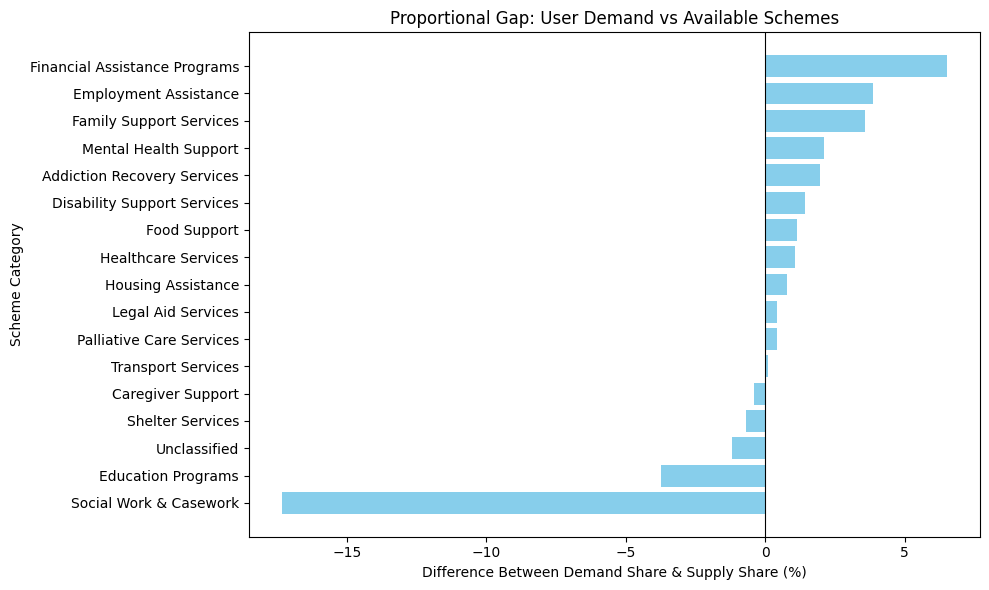

In [55]:
import matplotlib.pyplot as plt

df_prop_gap_sorted = df_prop_gap.sort_values('share_gap', ascending=True)

plt.figure(figsize=(10, 6))
plt.barh(df_prop_gap_sorted['schemes'], df_prop_gap_sorted['share_gap'] * 100, color='skyblue')
plt.axvline(0, color='black', linewidth=0.8)
plt.title('Proportional Gap: User Demand vs Available Schemes')
plt.xlabel('Difference Between Demand Share & Supply Share (%)')
plt.ylabel('Scheme Category')
plt.tight_layout()
plt.show()

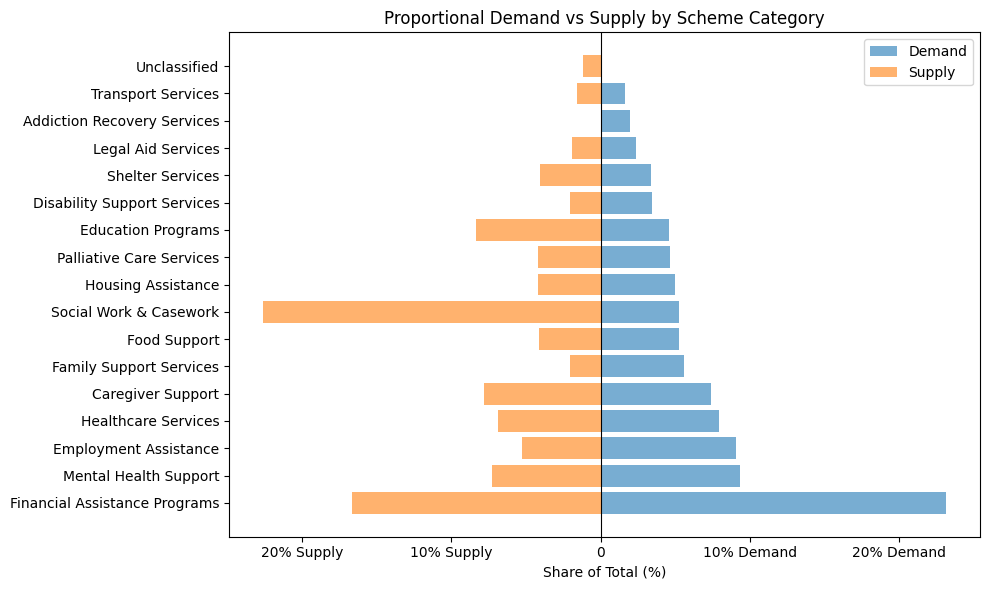

In [56]:
df_prop_gap_sorted = df_prop_gap.sort_values('demand_share', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(df_prop_gap_sorted['schemes'], df_prop_gap_sorted['demand_share'] * 100, label='Demand', alpha=0.6)
plt.barh(df_prop_gap_sorted['schemes'], -df_prop_gap_sorted['supply_share'] * 100, label='Supply', alpha=0.6)
plt.axvline(0, color='black', linewidth=0.8)
plt.title('Proportional Demand vs Supply by Scheme Category')
plt.xlabel('Share of Total (%)')
plt.xticks(
    [-20, -10, 0, 10, 20],
    ['20% Supply', '10% Supply', '0', '10% Demand', '20% Demand']
)
# plt.text(-max(df_prop_gap['supply_share'])*100*1.1, -1, "Supply", ha='right', fontsize=10, color='gray')
# plt.text(max(df_prop_gap['demand_share'])*100*1.1, -1, "Demand", ha='left', fontsize=10, color='gray')
plt.legend()
plt.tight_layout()
plt.show()

In [57]:
# demand_by_profile = (
#     df_exploded.groupby(['profile_category', 'scheme_category'])
#     .size()
#     .groupby(level=0)
#     .apply(lambda x: x / x.sum())  # convert to within-profile proportion
#     .reset_index(name='demand_share')
# )

demand_by_profile = (
    df_exploded.groupby(['profile_category', 'scheme_category'])
    .size()
    .reset_index(name='count')
)

# Compute within-profile proportions
demand_by_profile['demand_share'] = (
    demand_by_profile['count'] /
    demand_by_profile.groupby('profile_category')['count'].transform('sum')
)

demand_by_profile

,profile_category,scheme_category,count,demand_share
0,Caregiver,Addiction Recovery Services,1,0.005000
1,Caregiver,Caregiver Support,81,0.405000
2,Caregiver,Disability Support Services,11,0.055000
3,Caregiver,Education Programs,6,0.030000
4,Caregiver,Employment Assistance,16,0.080000
...,...,...,...,...
209,Woman in Need of Support,Mental Health Support,15,0.115385
210,Woman in Need of Support,Palliative Care Services,2,0.015385
211,Woman in Need of Support,Shelter Services,1,0.007692
212,Woman in Need of Support,Social Work & Casework,12,0.092308


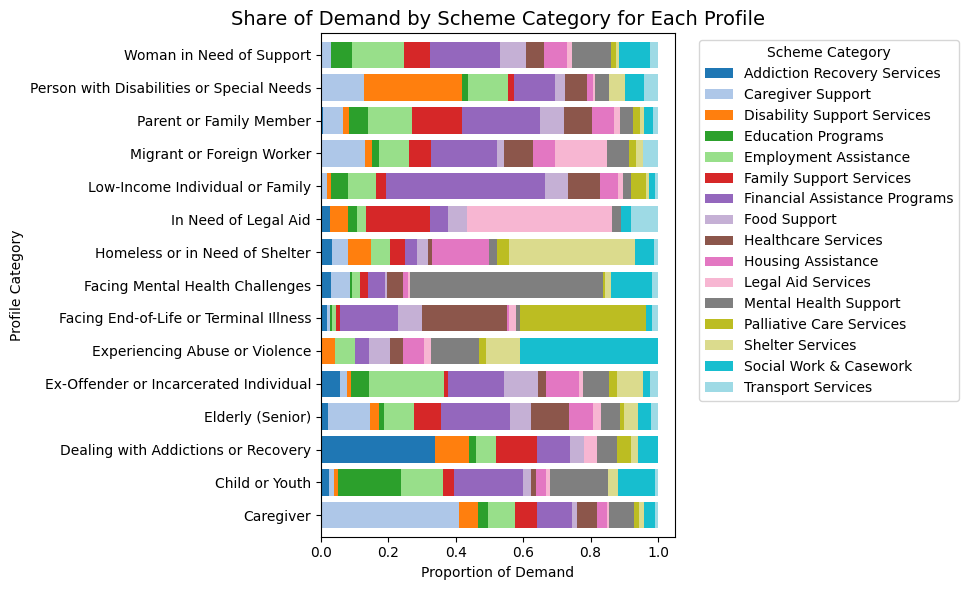

In [58]:
import matplotlib.pyplot as plt
import pandas as pd

# Pivot for plotting
pivot_df = demand_by_profile.pivot(
    index='profile_category',
    columns='scheme_category',
    values='demand_share'
).fillna(0)

# Plot
pivot_df.plot(
    kind='barh',
    stacked=True,
    figsize=(10, 6),
    width=0.8,
    colormap='tab20'
)

plt.title("Share of Demand by Scheme Category for Each Profile", fontsize=14)
plt.xlabel("Proportion of Demand")
plt.ylabel("Profile Category")
plt.legend(title="Scheme Category", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()